In [1]:
TRAIT = "Epilepsy"
CONDITION = 'Obesity'
QUESTION = f'What are the genetic factors related to {TRAIT} when considering the influence of {CONDITION}?'
print(f"Studied question: {QUESTION}")

NORMALIZE_GENE = False

Studied question: What are the genetic factors related to Epilepsy when considering the influence of Obesity?


# Introduction

In this question, we cannot collect data about both the trait (Epilepsy) and the condition (Obesity) from the same individuals. This is often the case in reality, where the condition is essentially another trait with available data from a different cohort, which cannot be simply merged with the trait dataset. This file is an example of doing two-stage regression analysis to answer the question in such scenarios.

## Two-stage Regression Analysis
This approach involves two steps to investigate the relationship among the trait, the condition, and the genes. Before doing the analysis, we need to prepare a gene expression dataset about the condition and the trait respectively.

In the first stage, we use the condition dataset to regress the condition on a few important genes, which are considered as "indicator genes". To choose the indicator genes, we query the OMIM database to get candidate genes that are found related to the condition according to biomedical knowledge, and preserve the candicate genes that exist in both the condition dataset and the trait dataset. If such genes exist, they serve as the "bridge" between the two datasets, making the two-stage regression possible. We can regress the condition on those genes in the condition dataset, and use the trained regression model to predict the condition on the trait dataset. This results in an augmented dataset with both trait and condition information from the same individuals.


In the second stage, we can directly conduct regression on the augmented trait dataset to explore the relationship between the genes, trait, and condition. Note that since the condition values were predicted from the indicator genes, and we include the condition as a regressor now, we need to exclude the indictor genes from the regressors in this stage to prevent co-linearity.


# 1. Preparation

## 1.1. GEO Data Download

## 1.2. Basic setups

In [2]:
# This cell is only for use on Google Colab. Skip it if you run your code in other environments

"""import os
from google.colab import drive

drive.mount('/content/drive', force_remount=True)
proj_dir = '/content/drive/MyDrive/AI4Science_Public'
os.chdir(proj_dir)"""

"import os\nfrom google.colab import drive\n\ndrive.mount('/content/drive', force_remount=True)\nproj_dir = '/content/drive/MyDrive/AI4Science_Public'\nos.chdir(proj_dir)"

In [3]:
import os
from utils import *

# data_root = './data'
data_root = '/media/techt/DATA'
dataset = 'GEO'
trait_subdir = "Epilepsy"
condition_subdir = "Obesity"
trait_accession_num = "GSE205661"
condition_accession_num = "GSE181339"
output_dir = './output'

trait_cohort_dir = os.path.join(data_root, dataset, trait_subdir, trait_accession_num)
condition_cohort_dir = os.path.join(data_root, dataset, condition_subdir, condition_accession_num)

In [4]:
trait_soft_file, trait_matrix_file = get_relevant_filepaths(trait_cohort_dir)
condition_soft_file, condition_matrix_file = get_relevant_filepaths(condition_cohort_dir)

In [5]:
trait_soft_file, trait_matrix_file

('/media/techt/DATA/GEO/Epilepsy/GSE205661/GSE205661_family.soft.gz',
 '/media/techt/DATA/GEO/Epilepsy/GSE205661/GSE205661-GPL13534_series_matrix.txt.gz')

# 2. Gene Data Preparation

## 2.1. Gene Data for Condition

In [6]:
condition_gene_annotation = get_gene_annotation(condition_soft_file)

In [7]:
condition_gene_annotation.head()

,ID,COL,ROW,NAME,SPOT_ID,CONTROL_TYPE,REFSEQ,GB_ACC,LOCUSLINK_ID,GENE_SYMBOL,...,UNIGENE_ID,ENSEMBL_ID,TIGR_ID,ACCESSION_STRING,CHROMOSOMAL_LOCATION,CYTOBAND,DESCRIPTION,GO_ID,SEQUENCE,SPOT_ID.1
0,1,192,328.0,GE_BrightCorner,GE_BrightCorner,pos,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,192,326.0,DarkCorner,DarkCorner,pos,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,192,324.0,DarkCorner,DarkCorner,pos,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,192,322.0,A_21_P0014386,A_21_P0014386,FALSE,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,unmapped,NaN,NaN,NaN,AATACATGTTTTGGTAAACACTCGGTCAGAGCACCCTCTTTCTGTG...,NaN
4,5,192,320.0,A_33_P3396872,A_33_P3396872,FALSE,NM_001105533,NM_001105533,79974.0,CPED1,...,Hs.189652,NaN,NaN,ref|NM_001105533|gb|AK025639|gb|BC030538|tc|TH...,chr7:120901888-120901947,hs|7q31.31,Homo sapiens cadherin-like and PC-esterase dom...,GO:0005783(endoplasmic reticulum),GCTTATCTCACCTAATACAGGGACTATGCAACCAAGAAACTGGAAA...,NaN


In [8]:
condition_gene_name_col = 'GENE_SYMBOL'

In [9]:
condition_gene_mapping = get_gene_mapping(condition_gene_annotation, condition_gene_name_col)

In [10]:
condition_genetic_data = get_genetic_data(condition_matrix_file)

In [11]:
condition_genetic_data = apply_gene_mapping(condition_genetic_data, condition_gene_mapping)

In [12]:
if NORMALIZE_GENE:
    condition_genetic_data = normalize_gene_symbols_in_index(condition_genetic_data)

## 2.2. Gene Data for Trait

In [13]:
trait_gene_annotation = get_gene_annotation(trait_soft_file)

In [14]:
trait_gene_annotation.head()

,ID,Name,AddressA_ID,AlleleA_ProbeSeq,AddressB_ID,AlleleB_ProbeSeq,Infinium_Design_Type,Next_Base,Color_Channel,Forward_Sequence,...,DMR,Enhancer,HMM_Island,Regulatory_Feature_Name,Regulatory_Feature_Group,DHS,RANGE_START,RANGE_END,RANGE_GB,SPOT_ID
0,cg00035864,cg00035864,31729416,AAAACACTAACAATCTTATCCACATAAACCCTTAAATTTATCTCAA...,NaN,NaN,II,NaN,NaN,AATCCAAAGATGATGGAGGAGTGCCCGCTCATGATGTGAAGTACCT...,...,NaN,NaN,NaN,NaN,NaN,NaN,8553009.0,8553132.0,NC_000024.9,NaN
1,cg00050873,cg00050873,32735311,ACAAAAAAACAACACACAACTATAATAATTTTTAAAATAAATAAAC...,31717405,ACGAAAAAACAACGCACAACTATAATAATTTTTAAAATAAATAAAC...,I,A,Red,TATCTCTGTCTGGCGAGGAGGCAACGCACAACTGTGGTGGTTTTTG...,...,NaN,NaN,Y:9973136-9976273,NaN,NaN,NaN,9363356.0,9363479.0,NC_000024.9,NaN
2,cg00061679,cg00061679,28780415,AAAACATTAAAAAACTAATTCACTACTATTTAATTACTTTATTTTC...,NaN,NaN,II,NaN,NaN,TCAACAAATGAGAGACATTGAAGAACTAATTCACTACTATTTGGTT...,...,NaN,NaN,NaN,NaN,NaN,NaN,25314171.0,25314294.0,NC_000024.9,NaN
3,cg00063477,cg00063477,16712347,TATTCTTCCACACAAAATACTAAACRTATATTTACAAAAATACTTC...,NaN,NaN,II,NaN,NaN,CTCCTGTACTTGTTCATTAAATAATGATTCCTTGGATATACCAAGT...,...,NaN,NaN,NaN,NaN,NaN,NaN,22741795.0,22741918.0,NC_000024.9,NaN
4,cg00121626,cg00121626,19779393,AAAACTAATAAAAATAACTTACAAACCAAATACTATACCCTACAAC...,NaN,NaN,II,NaN,NaN,AGGTGAATGAAGAGACTAATGGGAGTGGCTTGCAAGCCAGGTACTG...,...,NaN,NaN,NaN,NaN,NaN,NaN,21664296.0,21664419.0,NC_000024.9,NaN


In [15]:
trait_gene_name_col = 'UCSC_RefGene_Name'

In [16]:
trait_gene_mapping = get_gene_mapping(trait_gene_annotation, trait_gene_name_col)

In [17]:
trait_genetic_data = get_genetic_data(trait_matrix_file)

In [18]:
trait_genetic_data = apply_gene_mapping(trait_genetic_data, trait_gene_mapping)

In [19]:
if NORMALIZE_GENE:
    trait_genetic_data = normalize_gene_symbols_in_index(trait_genetic_data)

## 2.3. Confirmation of Data Suitability

In [20]:
# Find the genes related to the trait according to biomedical knowledge from OMIM

trait_gene_rel_path = os.path.join(data_root, 'Summary_Corresponding_Gene_Symbol.csv')
trait_gene_rel = pd.read_csv(trait_gene_rel_path)
trait_gene_rel = trait_gene_rel.loc[:, ['Disease Name', 'Corresponding_Gene_Symbol']].set_index('Disease Name')
# Convert to lower case
# trait_gene_rel = trait_gene_rel.apply(lambda x: x.astype(str).str.lower())
# trait_gene_rel.index = trait_gene_rel.index.str.lower()

In [21]:
condition_related_genes = trait_gene_rel.loc[CONDITION].tolist()[0].strip().split(',')
condition_related_genes = [gn.strip() for gn in condition_related_genes]
if NORMALIZE_GENE:
    condition_related_genes = normalize_gene_symbols(condition_related_genes)
print(f"Genes related to the condition '{CONDITION}' according to domain knowledge, {condition_related_genes}")

Genes related to the condition 'Obesity' according to domain knowledge, ['LEP', 'PPARG', 'POMC', 'MC4R', 'ENPP1', 'ADCY3']


In [22]:
genes_in_trait_data = set(trait_genetic_data.index)
genes_in_condition_data = set(condition_genetic_data.index)

common_genes_across_datasets = genes_in_trait_data.intersection(genes_in_condition_data)
if len(common_genes_across_datasets) == 0:
    print("The trait and condition datasets have no genes in common. Please try other datasets")
else:
    print(f"The trait and condition datasets have {len(common_genes_across_datasets)} genes in common, such as {list(common_genes_across_datasets)[:10]}.")
    common_genes = common_genes_across_datasets.intersection(set(condition_related_genes))
    if len(common_genes) > 0:
        gene_regressors_for_condition = list(common_genes)
        print(f"Found {len(common_genes)} candidate genes that can be used in two-step regression analysis, such as {gene_regressors_for_condition[:10]}.")
    else:
        print(f"The condition and trait datasets have common genes, and we need to select indicator genes for the condition")

The trait and condition datasets have 10983 genes in common, such as ['ASB13', 'PRPF19', 'PLEKHM1', 'EIF1AX', 'PRAF2', 'SNRPD3', 'GOLGA7', 'UBB', 'MAFA', 'FASTKD1'].
Found 2 candidate genes that can be used in two-step regression analysis, such as ['POMC', 'ADCY3'].


# 3. Clinical Data Preparation

## Description

## Thrust 1: Acertain if the GEO sereies is suitable for the regression analysis
To determine if the GEO series is suitable for regression analysis, you need to assess whether it provides samples that include both the trait being analyzed and samples without the trait. If the series contains such samples, it can be used for regression analysis. However, if the series does not include both types of samples, alternative GEO series will need to be identified.

# Thrust 2: Understand the text information and  label the samples
To label the samples, it is important to thoroughly understand the details provided in the text. They offer information into the nature of the study, the overall design, and the characteristics of the samples, which help determine which samples possess the trait of interest (positive samples) and which do not (negative samples).

In this demo, the samples in the control group are removed, the samples without seizure (negative samples) are marked as 0, and the samples with seizure (positive samples) are marked as 1.

Note: The control group refers to a group of individuals or subjects in a scientific study or experiment that does not receive the experimental treatment or intervention.   Therefore, the trait of the samples in the control group remains unclear, we thus remove them.

## 3.1. Clinical Data for Trait

### Automatic Labeling
You can use ChatGPT to help understand the text information and label the samples.

## Prompt for understanding text

Analyze if the text {filtered_content} including samples with charateristic related to the trait {TRAIT} or not.
The output should only be yes or no.

## Code (I recommend going directly to the GPT website)
ascertain_prompt  = (f"Analyze if the text {filtered_content} including samples with charateristic related to the trait {TRAIT} or not. "
f"The output should only be yes or no")

response = openai.Completion.create(engine=deployment_name, prompt=ascertain_prompt, max_tokens=20)

text = response['choices'][0]['text']

print(text)

## Prompt for labeling

According to {filtered_content}, please create a table using Panda where the row name represents the trait {TRAIT} and the column names represent the GEO accessions of the samples. Then fill in value 0 for the samples without the trait {TRAIT} and  value 1 to the samples with the trait {TRAIT}. The output should only be a table that can be used by python

## Code (I recommend going directly to the GPT website)

Label_prompt = (f"According to {filtered_content}, please create a table using Panda where the row name represents the trait {TRAIT} and the column names represent the  GEO accessions of the samples. "
f" Then fill in value 0 for the samples without the trait {TRAIT} and the value 1 to the samples with the trait {TRAIT}"
f"The output should only be a table that can be used by python")

response = openai.Completion.create(engine=deployment_name, prompt=Label_prompt, max_tokens=500)

text = response['choices'][0]['text']

print(text)

In [23]:
background_prefixes = ['!Sample_geo_accession', '!Series_title', '!Series_summary', '!Series_overall_design', '!Sample_characteristics_ch1']

trait_background_info = get_background_info(trait_matrix_file, background_prefixes)
print(trait_background_info)

!Series_title	"Integrated analysis of expression profile and potential pathogenic mechanism of temporal lobe epilepsy with hippocampal sclerosis"
!Series_summary	"To investigate the potential pathogenic mechanism of temporal lobe epilepsy with hippocampal sclerosis (TLE+HS), we have employed analyzing of the expression profiles of microRNA/ mRNA/ lncRNA/ DNA methylation in brain tissues of hippocampal sclerosis (TLE+HS) patients. Brain tissues of six patients with TLE+HS and nine of normal temporal or parietal cortices (NTP) of patients undergoing internal decompression for traumatic brain injury (TBI) were collected. The total RNA was dephosphorylated, labeled, and hybridized to the Agilent Human miRNA Microarray, Release 19.0, 8x60K. The cDNA was labeled and hybridized to the Agilent LncRNA+mRNA Human Gene Expression Microarray V3.0，4x180K. For methylation detection, the DNA was labeled and hybridized to the Illumina 450K Infinium Methylation BeadChip. The raw data was extracted from

### Manual Labeling

In [24]:
def decode_trait_var(value):
    if value == 'tissue: Hippocampus':
        return 1
    else:
        return 0

In [25]:
clinical_prefixes = ['!Sample_geo_accession', '!Sample_characteristics_ch1']
trait_clinical_data = get_clinical_data(trait_background_info, clinical_prefixes)

In [26]:
trait_clinical_data

,!Sample_geo_accession,GSM6216198,GSM6216199,GSM6216200,GSM6216201,GSM6216202,GSM6216203,GSM6216204,GSM6216205,GSM6216206,GSM6216207,GSM6216208,GSM6216209,GSM6216210,GSM6216211,GSM6216212
0,!Sample_characteristics_ch1,tissue: Hippocampus,tissue: Hippocampus,tissue: Hippocampus,tissue: Hippocampus,tissue: Hippocampus,tissue: Hippocampus,tissue: Temporal lobe,tissue: Temporal lobe,tissue: Temporal lobe,tissue: Temporal lobe,tissue: Temporal lobe,tissue: Temporal lobe,tissue: Parietal lobe,tissue: Temporal lobe,tissue: Parietal lobe
1,!Sample_characteristics_ch1,gender: Female,gender: Male,gender: Male,gender: Female,gender: Female,gender: Male,gender: Female,gender: Male,gender: Female,gender: Male,gender: Male,gender: Male,gender: Male,gender: Male,gender: Male
2,!Sample_characteristics_ch1,age: 23y,age: 29y,age: 37y,age: 26y,age: 16y,age: 13y,age: 62y,age: 58y,age: 63y,age: 68y,age: 77y,age: 59y,age: 50y,age: 39y,age: 23y


In [27]:
trait_row_id = 0

trait_feature_data = get_feature_data(trait_clinical_data, trait_row_id, TRAIT, decode_trait_var)
trait_merged_data = add_binary_feature(trait_genetic_data, trait_feature_data, TRAIT)

In [28]:
trait_merged_data = trait_merged_data.T
trait_merged_data

,A1BG,A1CF,A2BP1,A2LD1,A2M,A2ML1,A4GALT,A4GNT,AAA1,AAAS,...,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3,psiTPTE22,tAKR,Epilepsy
GSM6216198,0.498235,0.909286,0.697852,0.849571,0.803357,0.881167,0.454591,0.887167,0.9117,0.157538,...,0.5251,0.332605,0.554000,0.519077,0.365947,0.522561,0.162056,0.225000,0.919,1.0
GSM6216199,0.479765,0.900571,0.702369,0.864786,0.831571,0.874278,0.437136,0.895333,0.9172,0.157769,...,0.2783,0.323442,0.559333,0.517308,0.375368,0.512585,0.139722,0.240278,0.934,1.0
GSM6216200,0.490882,0.900000,0.692183,0.846429,0.814643,0.844056,0.437409,0.872500,0.9123,0.153846,...,0.3173,0.331791,0.558600,0.508000,0.368316,0.517439,0.149056,0.240167,0.897,1.0
GSM6216201,0.527765,0.900857,0.684736,0.859429,0.771929,0.903000,0.440500,0.804333,0.8902,0.164000,...,0.6069,0.332116,0.560267,0.528846,0.317737,0.517293,0.157000,0.236278,0.933,1.0
GSM6216202,0.485706,0.895857,0.680550,0.820357,0.776429,0.838000,0.438864,0.842500,0.8885,0.161385,...,0.4872,0.325698,0.546733,0.519769,0.356000,0.514829,0.158444,0.246667,0.931,1.0
GSM6216203,0.464529,0.896857,0.679555,0.849429,0.788929,0.863778,0.444364,0.863500,0.9017,0.153462,...,0.2949,0.322256,0.548467,0.514000,0.364158,0.513976,0.133444,0.226056,0.950,1.0
GSM6216204,0.543765,0.905286,0.668049,0.842357,0.796500,0.889667,0.452727,0.876833,0.9155,0.175077,...,0.4943,0.327953,0.554667,0.507000,0.332474,0.512585,0.152444,0.231111,0.943,0.0
GSM6216205,0.530529,0.895000,0.678844,0.860214,0.821571,0.890611,0.449409,0.875167,0.9178,0.157308,...,0.2748,0.323163,0.553467,0.500308,0.347474,0.516390,0.150389,0.227222,0.939,0.0
GSM6216206,0.541882,0.920143,0.676294,0.848786,0.805357,0.851278,0.459182,0.860833,0.9167,0.158615,...,0.5138,0.336093,0.566867,0.526615,0.327684,0.525683,0.160889,0.229278,0.955,0.0
GSM6216207,0.558471,0.877429,0.700736,0.872500,0.852857,0.864000,0.434091,0.912667,0.9123,0.156769,...,0.2312,0.346721,0.576800,0.506615,0.386579,0.515854,0.128111,0.241389,0.958,0.0


## 3.2. Clinical Data for Condition

### Manual Labeling

In [29]:
condition_background_info = get_background_info(condition_matrix_file, background_prefixes)
print(condition_background_info)

!Series_title	"Study of the usefulness of human peripheral blood mononuclear cells for the analysis of metabolic recovery after weight loss (METAHEALTH-TEST)"
!Series_summary	"The aim of this study is to design and validate a test, METAHEALTH-TEST, based on gene expression analysis in blood cells, to quickly and easily analyse metabolic health. This test will be used to analyse metabolic improvement in overweight/obese individuals and in metabolically obese normal-weight (MONW) individuals after undergoing a weight loss intervention and/or an intervention for improvement in eating habits and lifestyle. Obesity and its medical complications are a serious health problem today. Using peripheral blood mononuclear cells (PBMC) as an easily obtainable source of transcriptomic biomarkers would allow to deepen into the knowledge of adaptations in response to increased adiposity that occur in internal homeostatic tissues, without the need of using invasive biopsies. Moreover, if PBMC were able 

In [30]:
def decode_condition_var(value):
    if value == 'group: OW/OB':
        return 1
    else:
        return 0

In [31]:
condition_clinical_data = get_clinical_data(condition_background_info, clinical_prefixes)
condition_clinical_data.head()

,!Sample_geo_accession,GSM5494930,GSM5494931,GSM5494932,GSM5494933,GSM5494934,GSM5494935,GSM5494936,GSM5494937,GSM5494938,...,GSM5494998,GSM5494999,GSM5495000,GSM5495001,GSM5495002,GSM5495003,GSM5495004,GSM5495005,GSM5495006,GSM5495007
0,!Sample_characteristics_ch1,gender: Man,gender: Man,gender: Woman,gender: Woman,gender: Woman,gender: Man,gender: Woman,gender: Woman,gender: Woman,...,gender: Woman,gender: Woman,gender: Man,gender: Man,gender: Man,gender: Man,gender: Man,gender: Woman,gender: Man,gender: Man
1,!Sample_characteristics_ch1,group: NW,group: OW/OB,group: MONW,group: OW/OB,group: NW,group: OW/OB,group: OW/OB,group: OW/OB,group: NW,...,group: OW/OB,group: OW/OB,group: OW/OB,group: NW,group: OW/OB,group: NW,group: OW/OB,group: OW/OB,group: OW/OB,group: NW
2,!Sample_characteristics_ch1,age: 21,age: 23,age: 10,age: 17,age: 11,age: 1,age: 18,age: 10,age: 12,...,age: 2,age: 2,age: 30,age: 17,age: 30,age: 19,age: 30,age: 2,age: 4,age: 19
3,!Sample_characteristics_ch1,fasting time: 6hr,fasting time: 4hr,fasting time: 6hr,fasting time: 4hr,fasting time: 4hr,fasting time: 6hr,fasting time: 4hr,fasting time: 6hr,fasting time: 4hr,...,fasting time: 6hr,fasting time: 4hr,fasting time: 4hr,fasting time: 6hr,fasting time: 6hr,fasting time: 4hr,fasting time: 4hr,fasting time: 6hr,fasting time: 4hr,fasting time: 6hr
4,!Sample_characteristics_ch1,timepoint: 0months,timepoint: 6months,timepoint: 0months,timepoint: 0months,timepoint: 0months,timepoint: 6months,timepoint: 6months,timepoint: 0months,timepoint: 0months,...,timepoint: 6months,timepoint: 0months,timepoint: 0months,timepoint: 0months,timepoint: 6months,timepoint: 0months,timepoint: 6months,timepoint: 0months,timepoint: 0months,timepoint: 0months


In [32]:
condition_row_id = 1

condition_feature_data = get_feature_data(condition_clinical_data, condition_row_id, CONDITION, decode_condition_var)
condition_merged_data = add_binary_feature(condition_genetic_data, condition_feature_data, CONDITION)

In [33]:
condition_merged_data = condition_merged_data.T
condition_merged_data

,A1BG,A1BG-AS1,A2M-AS1,A4GALT,AAAS,AACS,AADACL3,AAED1,AAGAB,AAK1,...,lnc-ZNF793-1,lnc-ZNF8-1,lnc-ZNF831-1,lnc-ZNF841-1,lnc-ZNF843-2,lnc-ZNHIT2-1,lnc-ZSCAN10-3,lnc-ZSWIM7-1,lnc-ZWINT-1,Obesity
GSM5494930,9.356389,6.588705,10.086590,6.087023,8.855058,6.453003,6.644548,8.574442,9.746953,8.111067,...,6.420560,7.156187,4.720504,6.250489,5.531711,5.607097,7.013670,6.007648,9.925314,0.0
GSM5494931,9.580217,6.861172,8.589913,5.958440,8.172307,6.070650,6.281522,8.541663,9.658012,8.342455,...,6.511561,7.407747,5.147163,6.689527,4.936741,5.791543,6.693026,6.502479,9.802190,1.0
GSM5494932,9.920784,7.055549,9.467662,6.690681,8.768802,6.703954,7.138168,7.638004,9.096505,8.249213,...,6.764327,7.472050,4.954556,6.397341,5.161682,6.335014,7.191005,6.874584,10.175204,0.0
GSM5494933,9.504974,6.792186,7.930585,5.814862,8.708854,6.803403,5.934699,8.047914,9.902677,7.866595,...,6.066324,6.668565,4.590746,6.018844,5.233187,5.384871,6.725039,5.865558,9.529888,1.0
GSM5494934,9.533504,7.192053,9.596064,5.822462,8.534389,6.751145,6.999438,8.174029,8.589853,8.513349,...,6.032859,6.321767,4.847594,6.752275,5.003696,5.973129,7.409849,6.850505,10.499701,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GSM5495003,9.838970,7.523552,9.046983,6.697867,8.848680,7.336287,6.809151,7.955837,9.434334,7.995361,...,6.433361,7.141827,5.953371,6.947847,5.897761,6.316877,7.440641,6.708521,9.378073,0.0
GSM5495004,9.807525,7.071518,8.999367,6.329302,8.456660,7.068365,6.736399,7.913941,9.067750,8.219228,...,6.601839,6.807179,5.784692,6.735757,6.228791,6.174487,7.127085,6.495594,9.405521,1.0
GSM5495005,9.834407,7.480286,8.712552,6.283686,8.722496,7.056443,6.972152,7.971760,9.209239,8.263851,...,6.731508,7.110267,5.719551,6.957694,5.972672,6.467393,7.310862,6.807400,9.658181,1.0
GSM5495006,9.777699,7.482379,9.702852,6.623779,8.856997,7.177422,7.021150,7.849326,9.143579,8.284696,...,6.488209,7.030179,5.915960,6.753858,6.172868,6.473956,7.866163,6.875553,10.306992,1.0


# 4. The First Stage Regression Analysis

### Preliminary analysis for condition regression

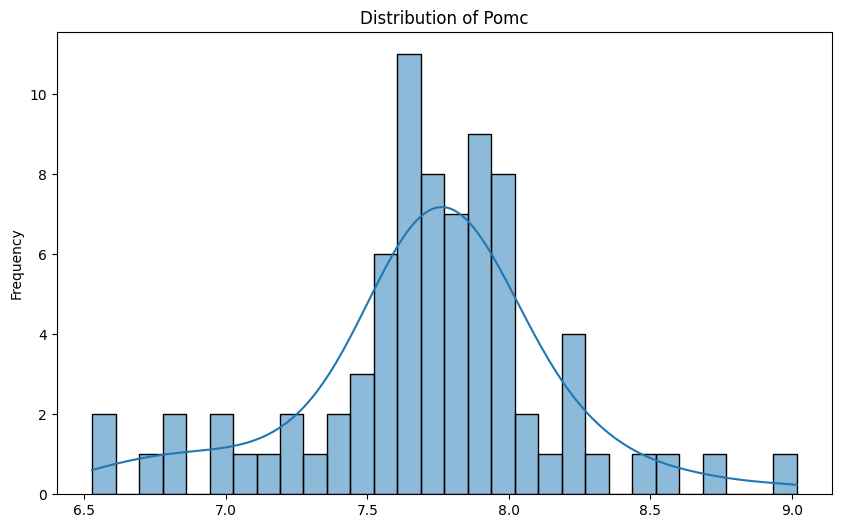

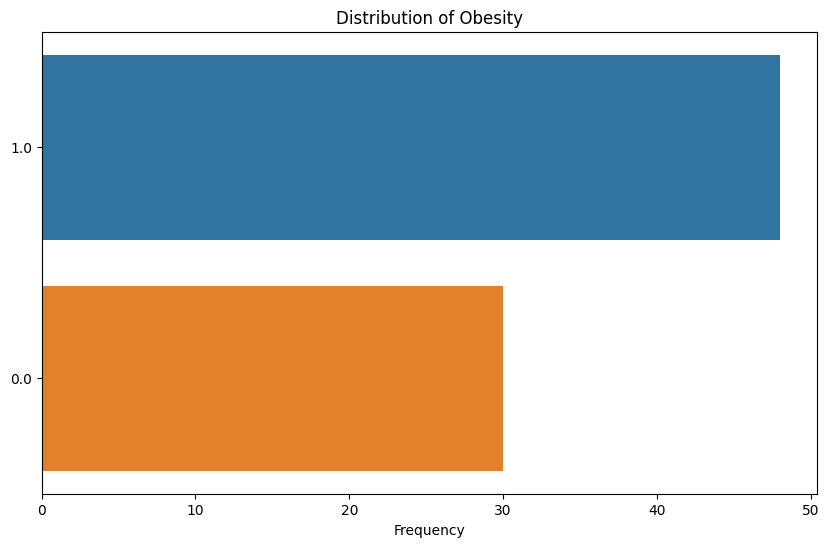

In [34]:
condition_feature_cols = condition_merged_data.columns.tolist()[:-1]
gene_list = [gene_regressors_for_condition[0]]  # Only show one gene

# Sample usage:
analyze_distributions(condition_merged_data, numerical_columns=[*gene_list], categorical_columns=[CONDITION])

### Do Regression Over Gene Data for Condition

In [35]:
X_condition = condition_merged_data[gene_regressors_for_condition].values
y_condition = condition_merged_data[CONDITION].values

# X_condition, _ = normalize_data(X_condition)
cv_mean, cv_std = cross_validation_with_lasso(X_condition, y_condition)

print(f'The cross-validation accuracy is {(cv_mean * 100):.2f}% ± {(cv_std * 100):.2f}%')

The cross-validation accuracy is 65.33% ± 6.53%


In [36]:
# Select relevant columns and convert to numpy array
print("Common gene regressors for condition and trait", gene_regressors_for_condition)

normalized_X_condition, _ = normalize_data(X_condition)

model = LogisticRegression(penalty='l1', solver='liblinear', random_state=42)
model.fit(normalized_X_condition, y_condition)

Common gene regressors for condition and trait ['POMC', 'ADCY3']


LogisticRegression(penalty='l1', random_state=42, solver='liblinear')

### Condition Prediction

In [37]:
# Select relevant columns and convert to numpy array
regressors_in_trait = trait_merged_data[gene_regressors_for_condition].values
normalized_regressors_in_trait, _ = normalize_data(regressors_in_trait)
predicted_condition = model.predict_proba(normalized_regressors_in_trait)[:, 1]

In [38]:
#Add the predicted condition to the gene data for trait
trait_merged_data.insert(0, CONDITION, predicted_condition)
trait_merged_data = trait_merged_data.drop(columns=gene_regressors_for_condition)
trait_merged_data.head()

,Obesity,A1BG,A1CF,A2BP1,A2LD1,A2M,A2ML1,A4GALT,A4GNT,AAA1,...,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3,psiTPTE22,tAKR,Epilepsy
GSM6216198,0.672132,0.498235,0.909286,0.697852,0.849571,0.803357,0.881167,0.454591,0.887167,0.9117,...,0.5251,0.332605,0.554000,0.519077,0.365947,0.522561,0.162056,0.225000,0.919,1.0
GSM6216199,0.690948,0.479765,0.900571,0.702369,0.864786,0.831571,0.874278,0.437136,0.895333,0.9172,...,0.2783,0.323442,0.559333,0.517308,0.375368,0.512585,0.139722,0.240278,0.934,1.0
GSM6216200,0.671753,0.490882,0.900000,0.692183,0.846429,0.814643,0.844056,0.437409,0.872500,0.9123,...,0.3173,0.331791,0.558600,0.508000,0.368316,0.517439,0.149056,0.240167,0.897,1.0
GSM6216201,0.697817,0.527765,0.900857,0.684736,0.859429,0.771929,0.903000,0.440500,0.804333,0.8902,...,0.6069,0.332116,0.560267,0.528846,0.317737,0.517293,0.157000,0.236278,0.933,1.0
GSM6216202,0.695657,0.485706,0.895857,0.680550,0.820357,0.776429,0.838000,0.438864,0.842500,0.8885,...,0.4872,0.325698,0.546733,0.519769,0.356000,0.514829,0.158444,0.246667,0.931,1.0


# 5. The Second Stage Regression Analysis

###  Preliminary analysis for trait regression

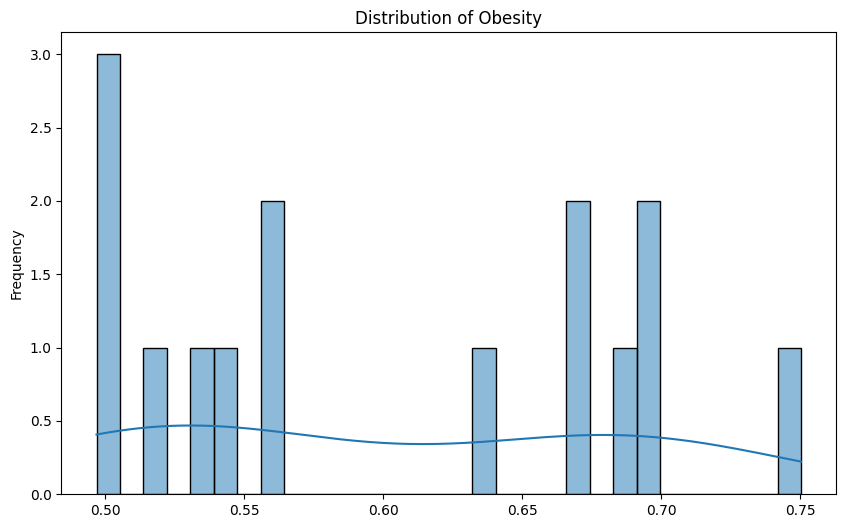

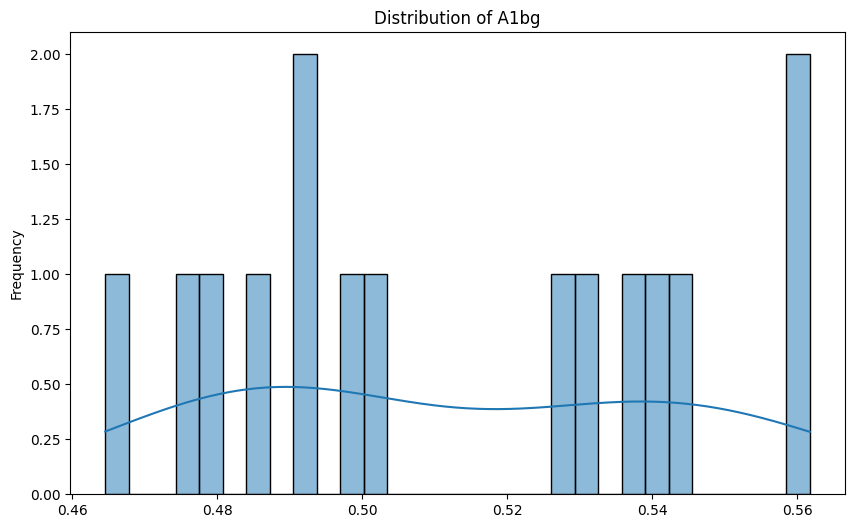

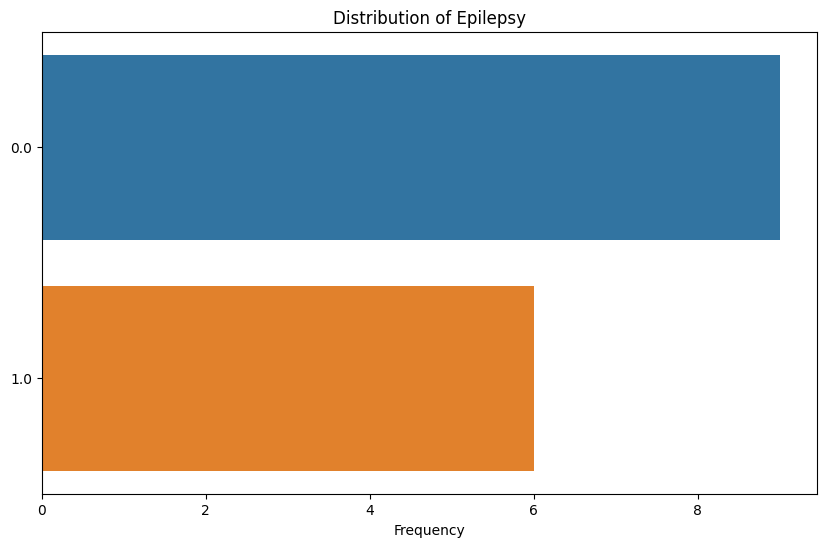

In [40]:
trait_feature_cols = trait_merged_data.columns.tolist()
trait_feature_cols.remove(TRAIT)
gene_list = [trait_feature_cols[1]]

# Sample usage:
analyze_distributions(trait_merged_data, numerical_columns=[CONDITION, *gene_list], categorical_columns=[TRAIT])

## Do Regression & Cross Validation Over Gene Data for Trait

In [41]:
# Select relevant columns and convert to numpy array
X_trait = trait_merged_data.drop(columns=[TRAIT]).values
y_trait = trait_merged_data[TRAIT].values
cv_mean, cv_std = cross_validation_with_lmm(X_trait, y_trait)
print(f'The cross-validation accuracy is {(cv_mean * 100):.2f}% ± {(cv_std * 100):.2f}%')

The cross-validation accuracy is 66.67% ± 17.21%


In [42]:
trait_merged_data

,Obesity,A1BG,A1CF,A2BP1,A2LD1,A2M,A2ML1,A4GALT,A4GNT,AAA1,...,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3,psiTPTE22,tAKR,Epilepsy
GSM6216198,0.672132,0.498235,0.909286,0.697852,0.849571,0.803357,0.881167,0.454591,0.887167,0.9117,...,0.5251,0.332605,0.554000,0.519077,0.365947,0.522561,0.162056,0.225000,0.919,1.0
GSM6216199,0.690948,0.479765,0.900571,0.702369,0.864786,0.831571,0.874278,0.437136,0.895333,0.9172,...,0.2783,0.323442,0.559333,0.517308,0.375368,0.512585,0.139722,0.240278,0.934,1.0
GSM6216200,0.671753,0.490882,0.900000,0.692183,0.846429,0.814643,0.844056,0.437409,0.872500,0.9123,...,0.3173,0.331791,0.558600,0.508000,0.368316,0.517439,0.149056,0.240167,0.897,1.0
GSM6216201,0.697817,0.527765,0.900857,0.684736,0.859429,0.771929,0.903000,0.440500,0.804333,0.8902,...,0.6069,0.332116,0.560267,0.528846,0.317737,0.517293,0.157000,0.236278,0.933,1.0
GSM6216202,0.695657,0.485706,0.895857,0.680550,0.820357,0.776429,0.838000,0.438864,0.842500,0.8885,...,0.4872,0.325698,0.546733,0.519769,0.356000,0.514829,0.158444,0.246667,0.931,1.0
GSM6216203,0.750267,0.464529,0.896857,0.679555,0.849429,0.788929,0.863778,0.444364,0.863500,0.9017,...,0.2949,0.322256,0.548467,0.514000,0.364158,0.513976,0.133444,0.226056,0.950,1.0
GSM6216204,0.497300,0.543765,0.905286,0.668049,0.842357,0.796500,0.889667,0.452727,0.876833,0.9155,...,0.4943,0.327953,0.554667,0.507000,0.332474,0.512585,0.152444,0.231111,0.943,0.0
GSM6216205,0.534365,0.530529,0.895000,0.678844,0.860214,0.821571,0.890611,0.449409,0.875167,0.9178,...,0.2748,0.323163,0.553467,0.500308,0.347474,0.516390,0.150389,0.227222,0.939,0.0
GSM6216206,0.496768,0.541882,0.920143,0.676294,0.848786,0.805357,0.851278,0.459182,0.860833,0.9167,...,0.5138,0.336093,0.566867,0.526615,0.327684,0.525683,0.160889,0.229278,0.955,0.0
GSM6216207,0.637629,0.558471,0.877429,0.700736,0.872500,0.852857,0.864000,0.434091,0.912667,0.9123,...,0.2312,0.346721,0.576800,0.506615,0.386579,0.515854,0.128111,0.241389,0.958,0.0


In [43]:
# Conduct regression on the whole dataset
model = VariableSelection()

normalized_X_trait, _ = normalize_data(X_trait)
model.fit(normalized_X_trait, y_trait)

# Retrieve the coefficients
coefficients = model.getBeta().reshape(-1).tolist()
nlog_p_values = model.getNegLogP().reshape(-1).tolist()
p_values = [np.exp(-p) for p in nlog_p_values]

## 6. Discussion

In [44]:
import pandas as pd
from statsmodels.stats.multitest import multipletests

# Create a DataFrame for the regression results
regression_df = pd.DataFrame({
    'Variable': trait_feature_cols,
    'Coefficient': coefficients,
    'p_value': p_values
})

# Extract information about the lifestyle condition's effect
#condition_effect = regression_df.iloc[0]
condition_effect = regression_df[regression_df['Variable'] == CONDITION]

# Report the effect of the lifestyle condition
print(f"Effect of the condition on the target variable:")
print(f"Variable: {CONDITION}")
print(f"Coefficient: {condition_effect['Coefficient']:.4f}")
print(f"p-value: {condition_effect['p_value']:.4g}\n")

Effect of the condition on the target variable:
Variable: Obesity


TypeError: unsupported format string passed to Series.__format__

In [ ]:
regression_df

In [ ]:
gene_regression_df = regression_df[regression_df['Variable'] != CONDITION]
gene_regression_df

In [ ]:
threshold = 0.05

# Apply the Benjamini-Hochberg correction, to get the corrected p-values
corrected_p_values = multipletests(gene_regression_df['p_value'], alpha=threshold, method='fdr_bh')[1]
gene_regression_df.loc[:, 'corrected_p_value'] = corrected_p_values

significant_genes = gene_regression_df.loc[gene_regression_df['corrected_p_value'] < threshold]
significant_genes_sorted = significant_genes.sort_values('corrected_p_value')

print(f"Found {len(significant_genes_sorted)} significant genes affecting the trait '{TRAIT}' conditional on the factor '{CONDITION}', with corrected p-value < {threshold}:")

print(significant_genes_sorted[['Variable', 'Coefficient', 'corrected_p_value']].to_string(index=False))

# Optionally, save this to a CSV file
os.makedirs(output_dir, exist_ok=True)
significant_genes_sorted.to_csv(os.path.join(output_dir, f'{TRAIT}_{CONDITION}_significant_genes.csv'), index=False)

In [ ]:
print(significant_genes_sorted["Variable"].tolist())